In [1]:
import pickle
import numpy as np
from sklearn.cluster import DBSCAN
import folium
import random
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
raw_data = pickle.load(open('data/geo_data_in_kyoto_city_RAW.pickle', 'rb'))

len(raw_data)

120321

In [3]:
raw_data[:10]

[{'P_v_id': 1188326, 'Longitude': '135.686645', 'Latitude': '35.047986'},
 {'P_v_id': 1188328, 'Longitude': '135.686645', 'Latitude': '35.047986'},
 {'P_v_id': 1188330, 'Longitude': '135.686645', 'Latitude': '35.047986'},
 {'P_v_id': 1905433, 'Longitude': '135.754108', 'Latitude': '34.985846'},
 {'P_v_id': 1905434, 'Longitude': '135.754108', 'Latitude': '34.985846'},
 {'P_v_id': 1905437, 'Longitude': '135.854187', 'Latitude': '35.01411'},
 {'P_v_id': 2157995, 'Longitude': '135.796999', 'Latitude': '34.925968'},
 {'P_v_id': 2602768, 'Longitude': '135.74604', 'Latitude': '35.000472'},
 {'P_v_id': 2610454, 'Longitude': '135.747756', 'Latitude': '35.013407'},
 {'P_v_id': 2610472, 'Longitude': '135.747756', 'Latitude': '35.013407'}]

In [4]:
raw_points = []

for p in raw_data:
    raw_points.append([float(p['Latitude']), float(p['Longitude'])])
    
raw_points = np.array(raw_points)
len(raw_points)

120321

In [5]:
geo_data_in_kyoto_city_dict = {}

for x in raw_data:
    key = (float(x['Latitude']), float(x['Longitude']))
    if key not in geo_data_in_kyoto_city_dict:
        geo_data_in_kyoto_city_dict[key] = [x['P_v_id']]
    else:
        geo_data_in_kyoto_city_dict[key].append(x['P_v_id'])
        

In [6]:
# Convert to radians

# raw_radian = np.radians(raw_points)
input_geo_deg_array = np.array(list(geo_data_in_kyoto_city_dict.keys()))
raw_radian = np.radians(input_geo_deg_array)



In [7]:
len(raw_radian)

34066

In [8]:
def dbscan_clustering(eps, min_samples, data): 
    eps = eps/6371.0088
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, algorithm='ball_tree', metric='haversine')
    
    dbscan.fit(data)
    labels = dbscan.labels_
    
    print(len(labels))
    print(len(input_geo_deg_array))
    
    clustering_result = {}
    for i in range(len(labels)):
        if labels[i] not in clustering_result:
            clustering_result[labels[i]] = []
        clustering_result[labels[i]].append(input_geo_deg_array[i])
        
    how_many_clusters = max(clustering_result.keys()) + 1
    
    return clustering_result, labels

In [9]:
result, labels = dbscan_clustering(0.05, 10, raw_radian)

34066
34066


In [10]:
max(labels)

234

In [11]:
used_label = []
plot_points = []
c_list = []
for k in result: 
    if k==-1:
        continue
    l = random.randint(1,len(labels))
    while l in used_label:
        l = random.randint(1, len(labels))
    for p in result[k]:
        plot_points.append(p)
        c_list.append(l)
plot_points = np.array(plot_points)
c_list = np.array(c_list)

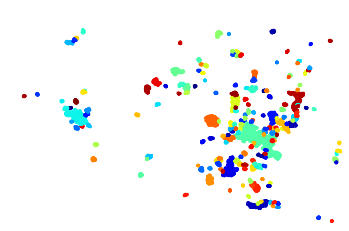

In [12]:
import matplotlib as mpl
plt.xlim([135.636645, 135.820645])
plt.ylim([34.957986, 35.073986])
plt.rcParams["figure.figsize"] = [15,10]

cmap = plt.get_cmap('jet', len(labels))

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.scatter(plot_points[:,1],plot_points[:,0], c=c_list, cmap=cmap, s=5)

# plt.savefig('fig/dbscan.png', bbox_inches='tight')

In [13]:
# dbscan_map = folium.Map(location=[34.48885,135.3916],zoom_start=8)

# for p in result:
#     if p == -1:
#         continue
#     folium.Circle(
#         radius=1,
#         location = p,
#         color='red',
#         fill=True,
#         fill_color = 'red',
#         fill_opacity = 1
#     ).add_to(dbscan_map)

# dbscan_map

In [14]:
#重複部分の矩形
def intersect_bound(a, b):
    x1 = max(a.x1, b.x1)
    y1 = max(a.y1, b.y1)
    x2 = min(a.x2, b.x2)
    y2 = min(a.y2, b.y2)
    return x1, y1, x2, y2

# def is_rectangle(x1, y1, x2, y2):
#     return x1 <= x2 and y1 <= y2

# 重複条件
def is_rectangle(rec):
    x1 = rec[0]
    y1 = rec[1]
    x2 = rec[2]
    y2 = rec[3]
    return x1 <= x2 and y1 <= y2

# 重複判定
def has_intersect(a, b):
    return is_rectangle(intersect_bound(a, b))

# 重複部分の矩形インスタンスを返す
def intersect(a, b):
    return Rectangle(max(a.x1, b.x1), max(a.y1, b.y1),
        min(a.x2, b.x2), min(a.y2, b.y2))
    
# 矩形の面積計算
def area_calculate(rect):
    return (rect.x2 - rect.x1) * (rect.y2 - rect.y1)

# クラス定義
class Rectangle(object):
    def __init__(self, x1, y1, x2, y2):
        if not is_rectangle((x1, y1, x2, y2)):
#             raise ValueError("Coordinates are invalid.\n" +
#                              "Rectangle" + str((x1, y1, x2, y2)))
            print("an error ocurred with Rectangle" + str((x1, y1, x2, y2)))
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2

    def __repr__(self):
        return ("Rectangle" + str((self.x1, self.y1, self.x2, self.y2)))



In [15]:
def get_dbscan_rec_dic(clustering_result):
    """
    クラスタリング結果を入力にとり、各クラスタを被覆する最小矩形を作る
    
    Parameters
    ----------
    clustering_result : {クラスタ1:[位置座標配列１，位置座標配列2,...], クラスタ2:[位置座標配列１，位置座標配列2,...]}　という辞書
    
    Returns
    -------
    dbscan_rec_dic : dict
        DBSCANで生成された各クラスタの矩形を表す辞書。 {クラスタ番号 : Rectangle(min_x, min_y, max_x, max_y), ...} このx,yの値は、緯度経度ではなく、平面座標系に変換した値。
    """
    
    wgs84 = pyproj.Proj(init='EPSG:4326') # WGS84 緯度経度
    rect6 = pyproj.Proj(init='EPSG:2448') # 平面直角座標6系

    dbscan_rec_dic = {}

    for key in clustering_result:
        lats = [x[0] for x in clustering_result[key]]
        lngs = [x[1] for x in clustering_result[key]]
        min_lat = min(lats)
        min_lng = min(lngs)
        max_lat = max(lats)
        max_lng = max(lngs)
        min_x, min_y = pyproj.transform(wgs84, rect6, min_lng, min_lat)
        max_x, max_y = pyproj.transform(wgs84, rect6, max_lng, max_lat)
        # ここに、平面座標系への変換をかませる
        dbscan_rec_dic[key] = Rectangle(min_x, min_y, max_x, max_y)
        
    return dbscan_rec_dic

In [16]:
def dbscan_mbr(result):
    dbscan_rec_dic = {}

    for key in result:
        if key==-1:
            continue
        lats = [x[0] for x in result[key]]
        lngs = [x[1] for x in result[key]]
        min_lat = min(lats)
        min_lng = min(lngs)
        max_lat = max(lats)
        max_lng = max(lngs)
        dbscan_rec_dic[key] = Rectangle(min_lat, min_lng, max_lat, max_lng)
    return dbscan_rec_dic

In [17]:
# 10 Typical MBR for tuning
typical_MBR = [
       [35.026399, 135.797287, 35.027682, 135.799124],
       [34.982715, 135.708253, 34.985343, 135.711431],
       [34.979333, 135.746247, 34.983067, 135.749229],
       [34.985190, 135.741425, 34.987484, 135.743882],
       [35.028084, 135.711858, 35.031405, 135.715256],
       [34.999215, 135.772571, 35.001333, 135.775053],
       [35.113069, 135.769121, 35.118962, 135.774616],
       [35.010058, 135.789245, 35.012630, 135.795986],
       [35.119007, 135.833763, 35.120256, 135.835130],
       [35.000546, 135.779901, 35.001284, 135.782844],
      ]

In [18]:
def poi_mbr(MBR):
    poi_mbr_dict = {}
    for m in range(len(MBR)):
        poi_mbr_dict[m] = Rectangle(MBR[m][0], MBR[m][1], MBR[m][2], MBR[m][3])
        
    return poi_mbr_dict
poi_mbr_dict = poi_mbr(typical_MBR)

In [19]:
def calc_final_dice_score_average(mainspot_rec_dic, dbscan_rec_dic):
    mainspot_max_dsc_dic = copy.deepcopy(mainspot_rec_dic)

    for spot_name, each_main_spot_rec in mainspot_rec_dic.items():
        each_main_spot_dice_score_list = []
        for each_dbscan_spot_rec in dbscan_rec_dic.values():
            if has_intersect(each_main_spot_rec, each_dbscan_spot_rec):
                each_main_spot_dice_score_list.append(dice_similarity(area_calculate(intersect(each_main_spot_rec, each_dbscan_spot_rec)), area_calculate(each_main_spot_rec), area_calculate(each_dbscan_spot_rec)))
        if len(each_main_spot_dice_score_list) == 0:
            mainspot_max_dsc_dic[spot_name] = 0
        else:
            mainspot_max_dsc_dic[spot_name] = max(each_main_spot_dice_score_list)
        
    c = 0
    dsc_sum = 0
    for x in mainspot_max_dsc_dic.values():
        if x != 0:
            c += 1
            dsc_sum += x
    final_dice_score_average = dsc_sum / c
    
    return final_dice_score_average

In [20]:
def calculate_percentage(mainspot_rec_dic, dbscan_rec_dic):
    dbscan_rec_dic = dbscan_rec_dic
    mainspot_rec_dic = mainspot_rec_dic

    # クラスタの合計面積を考える。
    total_area = 0
    for area in dbscan_rec_dic.values():
        # 各クラスタの面積計算
        total_area += area_calculate(area)
    
    area_sum = 0
    for p in mainspot_rec_dic.values():
        for q in dbscan_rec_dic.values():
            # 重複判定偽
            if not has_intersect(p,q):
                continue # 本当はラベル付とかを行うけど、今はパス
            # 重複判定真
            else:
                # 重複部の面積を計算する
                # 面積を足し合わせていく
                area_sum += area_calculate(intersect(p,q))

    # 割合を計算
    percentage = 100 * (area_sum / total_area)
    
    return percentage

In [21]:
def params_inputer(eps_list, min_samples_list):
    params_list = []
    for eps in eps_list:
        for min_sample in min_samples_list:
            params_list.append((eps, min_sample))
    return params_list

In [22]:
def param_result_dict(result_dict, params, score):
    
    result_dict[params] = score

In [23]:
# area_intersectは重複領域の面積（の総和）、area_a, area_bは各領域の面積（の総和）
def dice_similarity(area_intersect, area_a, area_b):
    # 定義通りに計算
    d = (2 * area_intersect) / (area_a + area_b)
    return d

In [24]:
from tqdm import tqdm_notebook as tqdm
import copy

# 20190121ver
result_dict = {}
plot_tuning_dict = {}
for each_param in tqdm(params_inputer([x / 1000 for x in range(50,150,50)],[x for x in range(5,50,5)])):
    dbscan_rec_dic = dbscan_mbr(dbscan_clustering(each_param[0], each_param[1], raw_radian)[0])
    print(len(dbscan_rec_dic))
    poi_rec_dic = poi_mbr_dict
    dice_score = calc_final_dice_score_average(poi_rec_dic, dbscan_rec_dic)
    param_result_dict(result_dict, each_param, dice_score)
#     param_result_dict(result_dict, each_param, dice_similarity(calc_intersect_area(dbscan_rec_dic, mainspot_rec_dic), calc_dbscan_area(dbscan_rec_dic), sum_mainspot_area))

<ipython-input-24-8616803f4cb4>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for each_param in tqdm(params_inputer([x / 1000 for x in range(50,150,50)],[x for x in range(5,50,5)])):


  0%|          | 0/18 [00:00<?, ?it/s]

34066
34066
448
34066
34066
235
34066
34066
159
34066
34066
116
34066
34066
90
34066
34066
83
34066
34066
77
34066
34066
70
34066
34066
66
34066
34066
287
34066
34066
165
34066
34066
114
34066
34066
94
34066
34066
84
34066
34066
74
34066
34066
68
34066
34066
67
34066
34066
58


In [25]:
pickle.dump(result_dict, open('output/dbscan_tuning_kyoto', 'wb'))

In [26]:
optimum_params = max(result_dict, key=result_dict.get)
optimum_params

(0.05, 25)

In [27]:
optimum_result = dbscan_clustering(optimum_params[0], optimum_params[1], raw_radian)[0]

34066
34066


In [28]:
optimum_result = dbscan_clustering(0.05, 5, raw_radian)[0]

34066
34066


In [29]:
len(optimum_result)

449

In [30]:
from haversine import haversine

def compute_cluster_density(data):
    density = {}
    for c in data:
        if c==-1:
            continue
            
        c_points = np.array(data[c])
        
        min_lat = min(c_points[:,0])
        min_lng = min(c_points[:,1])
        max_lat = max(c_points[:,0])
        max_lng = max(c_points[:,1])
        
        cluster_area = haversine((min_lat, min_lng), (min_lat, max_lng))*1000 * haversine((min_lat, min_lng), (max_lat, min_lng))*1000
#         cluster_area = haversine(up_left, up_right)*1000 * haversine(up_left, down_left)*1000
        cluster_photos = len(c_points)
#         if cluster_area < 2500:
#             cluster_density = 0
#         else:
        cluster_density = cluster_area/cluster_photos
        
        density[c] = cluster_density
    return density

In [31]:
density = compute_cluster_density(optimum_result)

In [32]:
# reference: gaussian kernel mean shift clustering
# https://github.com/arutaku/mean_shift 
# please see the above link for detail

from utils import mean_shift_1 as ms1

def spot_clustering(data, density):
    clusters = []
    photos = []
    gps_spotcenter_dict = {}
    gps_dbscancenter_dict = {}
    for c in data:
        if c==-1:
            continue
#         print('Cluster: ', c)
        c_points = np.array(data[c])
        dens = density[c]/max(density.values())
        
        if dens == 0.0:
            bandwidth = 50/100000
        else:
            bandwidth = (50 * dens  ) / 100000

        # Fix bandwidth
#         bandwidth = 0.0002
            
#         print('Bandwidth:', bandwidth)
        
        model = ms1.MeanShift(kernel_func=ms1.gaussian_kernel, bandwidth=bandwidth, n_jobs=-1)
        y_prime = model.fit_predict(c_points)
        
#         print(len(c_points))
#         print(len(y_prime))
        
        for center in range(len(model.cluster_centers_)):
            freq = 0
            y_prime_index = []
            for l in range(len(y_prime)):
                if y_prime[l] == center:
                    y_prime_index.append(l)
                    freq += 1
            if freq > 2:
                clusters.append(model.cluster_centers_[center])
                photos.append(freq)
                for index in y_prime_index:
                    gps_spotcenter_dict[tuple(data[c][index])] = model.cluster_centers_[center]
                    gps_dbscancenter_dict[tuple(data[c][index])] = c
        
    return clusters, photos, gps_spotcenter_dict, gps_dbscancenter_dict

In [33]:
clusters, photos, gps_spotcenter_dict, gps_dbscancenter_dict = spot_clustering(optimum_result, density)

/Users/junjiesun/GIT/POIDiscovery/utils/mean_shift_1.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.cluster_centers_by_popularity_ = np.array(sorted(final_clusters, key=lambda x: -x[1]))


In [34]:
spot_id_mapping = {}
sid = 0

for s in gps_spotcenter_dict:
    if tuple(gps_spotcenter_dict[s]) not in spot_id_mapping:
        spot_id_mapping[tuple(gps_spotcenter_dict[s])] = sid
        sid+=1
len(spot_id_mapping)

1512

In [35]:
columns = ['p_v_id', 'photo_gps', 'dbscan_id', 'spot_id', 'spot_gps' ]
df_data = []
for p in raw_data:
    temp = []
    key = tuple([float(p['Latitude']), float(p['Longitude'])])
    
    if key in gps_spotcenter_dict:
        temp.append(p['P_v_id'])
        temp.append(list(key))
        temp.append(gps_dbscancenter_dict[key])
        temp.append(spot_id_mapping[tuple(gps_spotcenter_dict[key])])
        temp.append(gps_spotcenter_dict[key])
        df_data.append(temp)
print(len(df_data))

spot_df = pd.DataFrame(data=df_data, columns=columns)
spot_df.head()

76147


,p_v_id,photo_gps,dbscan_id,spot_id,spot_gps
0,1905433,"[34.985846, 135.754108]",196,0,"[34.9859873642544, 135.75379232150414]"
1,1905434,"[34.985846, 135.754108]",196,0,"[34.9859873642544, 135.75379232150414]"
2,2610454,"[35.013407, 135.747756]",0,28,"[35.01377060722413, 135.74767536515327]"
3,2610472,"[35.013407, 135.747756]",0,28,"[35.01377060722413, 135.74767536515327]"
4,2638161,"[35.015324, 135.782347]",1,47,"[35.01502291209433, 135.7824664948519]"


In [36]:
spot_df.to_csv('output/Photo_to_spot.csv')

In [37]:
pickle.dump(clusters, open('output/spot_kyoto', 'wb'))

In [38]:
clusters = pickle.load(open('output/spot_kyoto', 'rb'))

In [39]:
len(optimum_result[1])

1436

In [47]:
from folium.plugins import Fullscreen

r_map = folium.Map(
        location=[35.005995, 135.761950],
        zoom_start=13
    )

for p in clusters:
    folium.Circle(
        radius=5,
        location = [p[0], p[1]],
        color='red',
        fill=True,
        fill_color = 'red',
        fill_opacity = 1
    ).add_to(r_map)
Fullscreen().add_to(r_map)
r_map

In [48]:
r_map.save('output/photo_cluster_spots.html')